## 5.4 ノード埋め込みの実装

### 5.4.2 データセットのダウンロードと前処理

In [1]:
# 依存ライブラリのインストール
# !pip install torch==2.0.0+cpu --index-url \
# https://download.pytorch.org/whl/cpu
# !pip install torch-cluster torch-scatter torch-sparse \
# -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

In [2]:
# 必要なライブラリのインストール
# !pip install torch-geometric==2.3.1 numpy==1.26.4 tqdm scikit-learn

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid

# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

Processing...
Done!


In [4]:
# Planetoid は torch_geometric の InMemoryDataset を継承している
# そのため、torch_geometric での学習が容易である
print(f"データセットの型 : {type(dataset)}")
print(f"ネットワークの型 : {type(dataset._data)}")

データセットの型 : <class 'torch_geometric.datasets.planetoid.Planetoid'>
ネットワークの型 : <class 'torch_geometric.data.data.Data'>


In [5]:
from collections import Counter
from torch_geometric.utils.convert import to_networkx

# PyTorch Geometric -> NetworkX への変換
cora_network = to_networkx(dataset._data, node_attrs=["y"])
print(f"ネットワークの型 : {type(cora_network)}")
print(f"ノード数 : {cora_network.number_of_nodes():,}")
print(f"エッジ数 : {cora_network.number_of_edges():,}")

ネットワークの型 : <class 'networkx.classes.digraph.DiGraph'>
ノード数 : 2,708
エッジ数 : 10,556


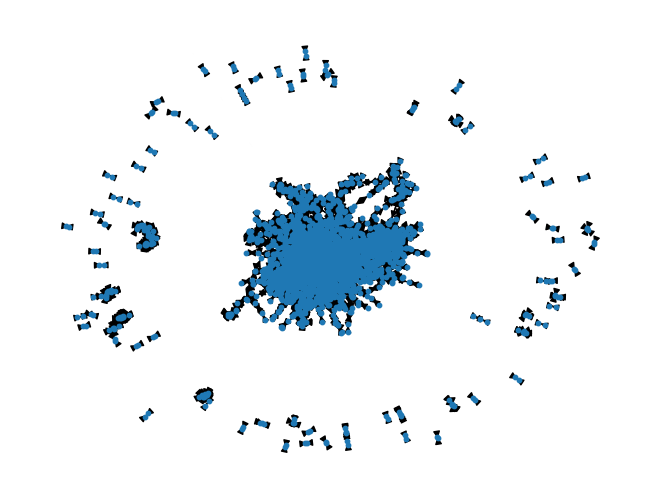

In [6]:
# Cora ネットワークの描画
nx.draw(cora_network, node_size=10)

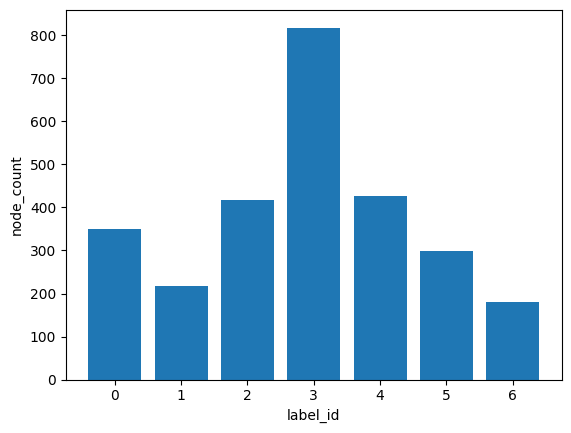

In [7]:
# 各論文の技術領域に対応する ID を取得
labels = nx.get_node_attributes(cora_network, "y")
label_counter = Counter(labels.values())

# ラベル分布を表示
plt.bar(
    [k for k, _ in sorted(label_counter.items())],
    [v for _, v in sorted(label_counter.items())],
)
plt.xlabel("label_id")
plt.ylabel("node_count")
plt.show()

In [9]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['x', 'train_mask', 'test_mask', 'y', 'val_mask']
tensor([ True,  True,  True,  ...,  True,  True, False])
tensor([False, False, False,  ..., False, False,  True])


### 5.4.3 node2vecによる分散表現の学習

In [11]:
import torch
from torch_geometric.nn import Node2Vec

# node2vec モデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
n2v_model = Node2Vec(
    splitted_data.edge_index,
    embedding_dim=64,
    walk_length=5,
    context_size=5,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=False,
).to(device)

# 最適化アルゴリズムの選択
n2v_optimizer = torch.optim.Adam(list(n2v_model.parameters()), lr=0.01)

In [12]:
from tqdm import tqdm

# node2vec の学習を行う関数の定義
def train_n2v() -> float:
    n2v_model.train()
    total_loss = 0.0
    loader = n2v_model.loader(batch_size=8, shuffle=True)
    # サンプリングしたランダムウォークの読み込み
    for pos_rw, neg_rw in tqdm(loader):
        n2v_optimizer.zero_grad()

        # 損失の計算
        loss = n2v_model.loss(
            pos_rw.to(device),
            neg_rw.to(device),
        )
        loss.backward()
        n2v_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 学習の実行
for epoch in range(30):
    loss = train_n2v()
    print(f"train loss : {loss:.4f}")

100%|██████████| 339/339 [00:00<00:00, 815.53it/s]


train loss : 5.5760


100%|██████████| 339/339 [00:00<00:00, 852.90it/s]


train loss : 3.7022


100%|██████████| 339/339 [00:00<00:00, 849.61it/s]


train loss : 2.9290


100%|██████████| 339/339 [00:00<00:00, 858.60it/s]


train loss : 2.4281


100%|██████████| 339/339 [00:00<00:00, 837.88it/s]


train loss : 2.0362


100%|██████████| 339/339 [00:00<00:00, 830.20it/s]


train loss : 1.7443


100%|██████████| 339/339 [00:00<00:00, 847.75it/s]


train loss : 1.5193


100%|██████████| 339/339 [00:00<00:00, 832.77it/s]


train loss : 1.3429


100%|██████████| 339/339 [00:00<00:00, 850.89it/s]


train loss : 1.2114


100%|██████████| 339/339 [00:00<00:00, 865.47it/s]


train loss : 1.1077


100%|██████████| 339/339 [00:00<00:00, 864.03it/s]


train loss : 1.0357


100%|██████████| 339/339 [00:00<00:00, 865.75it/s]


train loss : 0.9870


100%|██████████| 339/339 [00:00<00:00, 857.49it/s]


train loss : 0.9462


100%|██████████| 339/339 [00:00<00:00, 810.48it/s]


train loss : 0.9206


100%|██████████| 339/339 [00:00<00:00, 844.62it/s]


train loss : 0.8998


100%|██████████| 339/339 [00:00<00:00, 850.75it/s]


train loss : 0.8907


100%|██████████| 339/339 [00:00<00:00, 830.98it/s]


train loss : 0.8768


100%|██████████| 339/339 [00:00<00:00, 858.23it/s]


train loss : 0.8780


100%|██████████| 339/339 [00:00<00:00, 837.11it/s]


train loss : 0.8729


100%|██████████| 339/339 [00:00<00:00, 845.17it/s]


train loss : 0.8714


100%|██████████| 339/339 [00:00<00:00, 827.51it/s]


train loss : 0.8707


100%|██████████| 339/339 [00:00<00:00, 853.15it/s]


train loss : 0.8746


100%|██████████| 339/339 [00:00<00:00, 848.95it/s]


train loss : 0.8726


100%|██████████| 339/339 [00:00<00:00, 852.58it/s]


train loss : 0.8765


100%|██████████| 339/339 [00:00<00:00, 829.02it/s]


train loss : 0.8760


100%|██████████| 339/339 [00:00<00:00, 822.96it/s]


train loss : 0.8784


100%|██████████| 339/339 [00:00<00:00, 842.87it/s]


train loss : 0.8770


100%|██████████| 339/339 [00:00<00:00, 844.26it/s]


train loss : 0.8763


100%|██████████| 339/339 [00:00<00:00, 832.41it/s]


train loss : 0.8741


100%|██████████| 339/339 [00:00<00:00, 852.27it/s]

train loss : 0.8767


### 5.4.4 ロジスティック回帰による論文の技術領域の分類

In [13]:
# ノードに対応するベクトルを行列形式で獲得
embedding_matrix = n2v_model.embedding(
    torch.arange(splitted_data.num_nodes)
)
print(embedding_matrix.shape)

torch.Size([2708, 64])


In [14]:
# あらかじめ与えられた特徴量へのアクセス
print(splitted_data.x.shape)

torch.Size([2708, 1433])


In [16]:
# あらかじめ与えられた特徴量を用いたロジスティック回帰モデルの学習
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

baseline_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = splitted_data.x[splitted_data.train_mask].numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
baseline_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [17]:
# 評価データに対する推論
X_test = splitted_data.x[splitted_data.test_mask].numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = baseline_classifier.predict(X_test)
# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       140
           1       0.84      0.64      0.73        98
           2       0.88      0.86      0.87       175
           3       0.76      0.85      0.80       320
           4       0.79      0.81      0.80       167
           5       0.69      0.63      0.66       120
           6       0.75      0.65      0.69        63

    accuracy                           0.77      1083
   macro avg       0.77      0.73      0.75      1083
weighted avg       0.77      0.77      0.77      1083



In [18]:
# ノードの分散表現を特徴量に加えたロジスティック回帰モデルの学習
n2v_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = torch.cat(
    (
        splitted_data.x[splitted_data.train_mask],
        embedding_matrix[splitted_data.train_mask],
    ),
    dim=1,
).detach().numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
n2v_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [19]:
# テストデータに対する推論
X_test = torch.cat(
    (
        splitted_data.x[splitted_data.test_mask],
        embedding_matrix[splitted_data.test_mask],
    ),
    dim=1,
).detach().numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = n2v_classifier.predict(X_test)
# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       140
           1       0.90      0.77      0.83        98
           2       0.89      0.87      0.88       175
           3       0.82      0.86      0.84       320
           4       0.83      0.84      0.84       167
           5       0.81      0.77      0.79       120
           6       0.80      0.75      0.77        63

    accuracy                           0.82      1083
   macro avg       0.82      0.80      0.81      1083
weighted avg       0.82      0.82      0.82      1083

